<a href="https://colab.research.google.com/github/Serbeld/covid-chestxray-dataset/blob/master/Inception_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd

plt.rcParams["figure.figsize"] = (20,10)

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/covid-chestxray-dataset/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## global params
INIT_LR = 1e-5  # learning rate
EPOCHS = 70  # training epochs
BS = 5  # batch size


## load and prepare data
imagePaths = list(paths.list_images("/content/drive/My Drive/covid-chestxray-dataset-master/images/"))
data_from_csv = pd.read_csv("/content/drive/My Drive/covid-chestxray-dataset-master/metadata.csv")
name = data_from_csv['filename'].values
covid = data_from_csv['finding'].values

#print(imagePaths)
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:

    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-1]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    
    #In dataset
    for i in range(len(covid)):
      
      if label == name[i]:
        
        #print(label)

        # Positive COVID-19 => 1
        if covid[i] == 'COVID-19':
          data.append(image)
          labels.append(1)
          #print("COVID-19")

        # Negative COVID-19 => 0
        else:
          data.append(image)
          labels.append(0)
          #print("OTHERS")


In [0]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

TEST_SET_SIZE = 0.2

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); 
#print(labels) 
#COVID  [0. 1.]
#OTHERS [1. 0.]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=TEST_SET_SIZE, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")


In [5]:
## build network

#Inputs
inputs = Input(shape=(224, 224, 3), name='images')

#Inception Model
output1 = inception_v3.InceptionV3(include_top=False,weights="imagenet", 
                                  input_shape=(224, 224, 3),
                                  classes = 2)(inputs)

#AveragePooling2D
output = AveragePooling2D(pool_size=(4, 4), strides=None, 
                          padding='valid',name='AvgPooling')(output1)

#Flattened
output = Flatten(name='Flatten')(output)

#ReLU layer
output = Dense(1000, activation = 'relu',name='ReLU')(output)

#Dropout
output = Dropout(0.35,name='Dropout')(output)

#Dense layer
output = Dense(2, activation='softmax',name='softmax')(output)

# the actual model train)
model = Model(inputs=inputs, outputs=output)

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
AvgPooling (AveragePooling2D (None, 1, 1, 2048)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
ReLU (Dense)                 (None, 1000)              2049000   
_________________________________________________________________
Dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
softmax (Dense)              (None,

In [6]:
## train
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
35/35 [==============================] - 4s 125ms/step - loss: 0.6937 - accuracy: 0.6400 - val_loss: 0.5445 - val_accuracy: 0.7556
Epoch 2/70
35/35 [==============================] - 3s 80ms/step - loss: 0.6097 - accuracy: 0.7414 - val_loss: 0.5252 - val_accuracy: 0.7333
Epoch 3/70
35/35 [==============================] - 3s 82ms/step - loss: 0.5603 - accuracy: 0.7759 - val_loss: 0.4807 - val_accuracy: 0.7333
Epoch 4/70
35/35 [==============================] - 3s 82ms/step - loss: 0.5927 - accuracy: 0.7184 - val_loss: 0.4681 - val_accuracy: 0.7333
Epoch 5/70
35/35 [==============================] - 3s 81ms/step - loss: 0.5145 - accuracy: 0.7529 - val_loss: 0.4581 - val_accuracy: 0.7333
Epoch 6/70
35/35 [==============================] - 3s 80ms/step - loss: 0.4808 - accuracy: 0.7701 - val_loss: 0.4546 - val_accuracy: 0.7333
Epoch 7/70
35/35 [==============================] - 3

In [7]:
print("[INFO] saving COVID-19 detector model...")
model.save("/content/drive/My Drive/covid-chestxray-dataset-master/covid19_Inception.model", save_format="h5")

[INFO] saving COVID-19 detector model...


In [8]:
## eval
print("[INFO] evaluating network...")
predIdxs = (model.predict(testX, batch_size=BS))
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability
#print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[INFO] evaluating network...
[[ 9  3]
 [ 1 32]]
acc: 0.9111
sensitivity: 0.7500
specificity: 0.9697


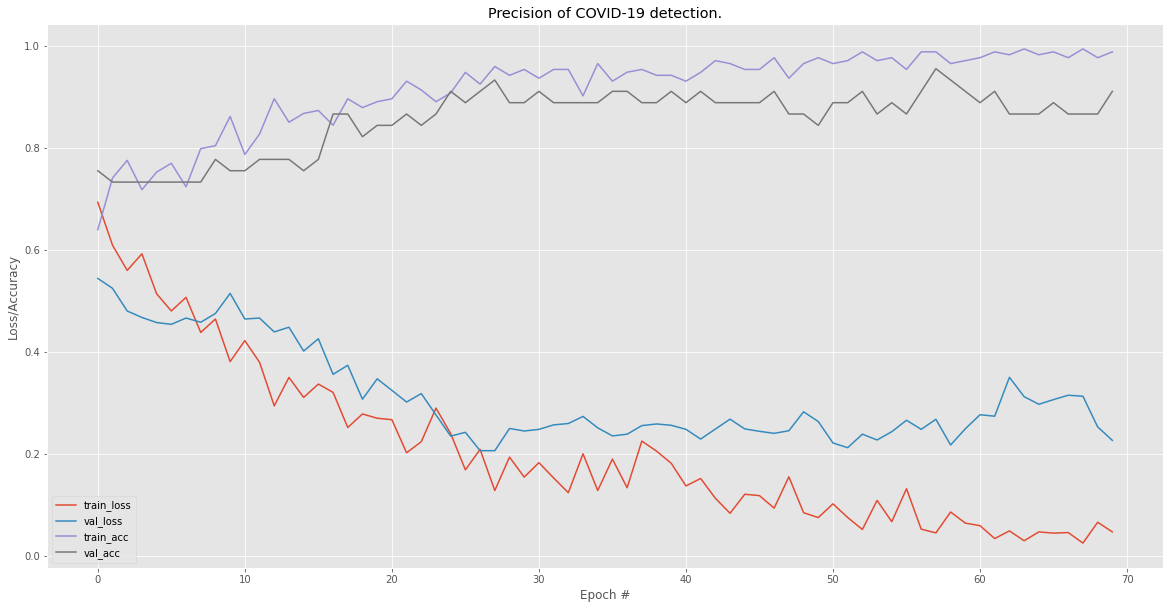

In [9]:
## explain
N = EPOCHS
plt.style.use("ggplot")
plt.figure(1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision of COVID-19 detection.")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/covid-chestxray-dataset-master/training_plot_Inception.png")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


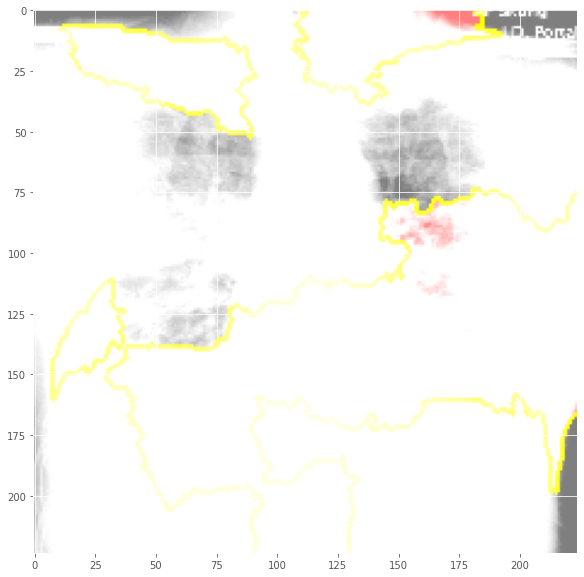


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 1


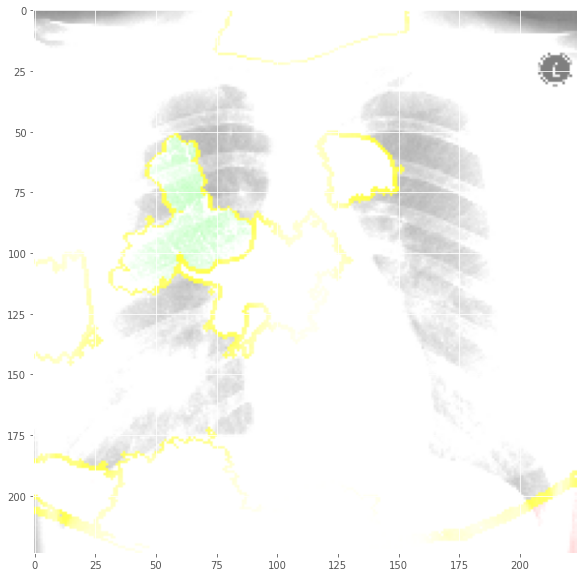


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


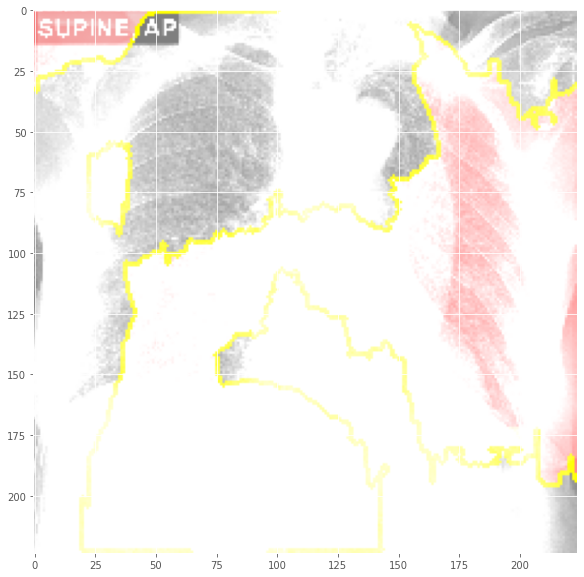


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


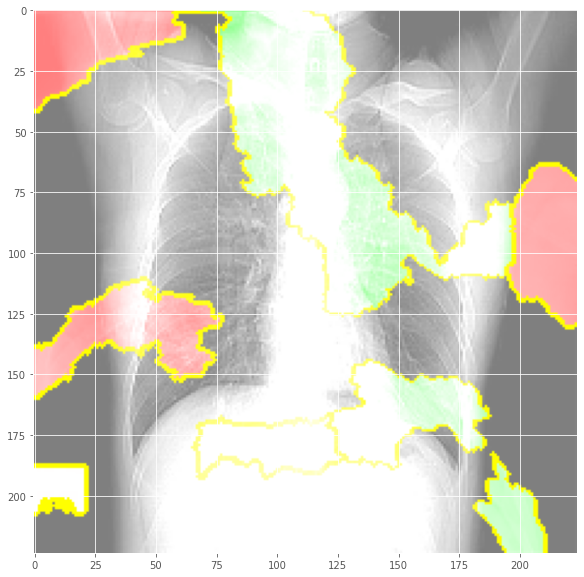


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


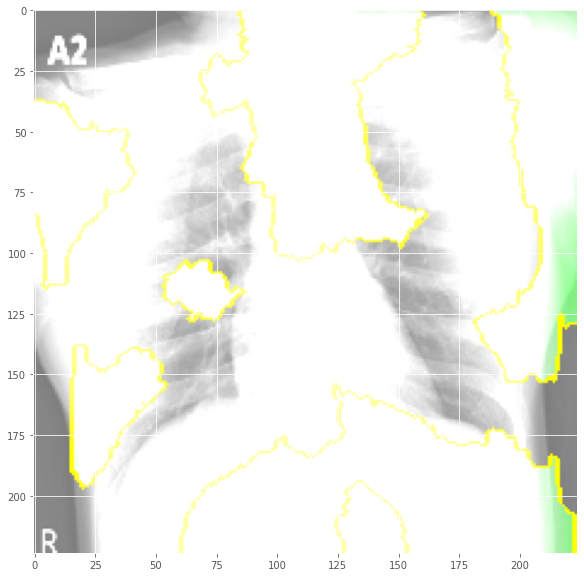


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


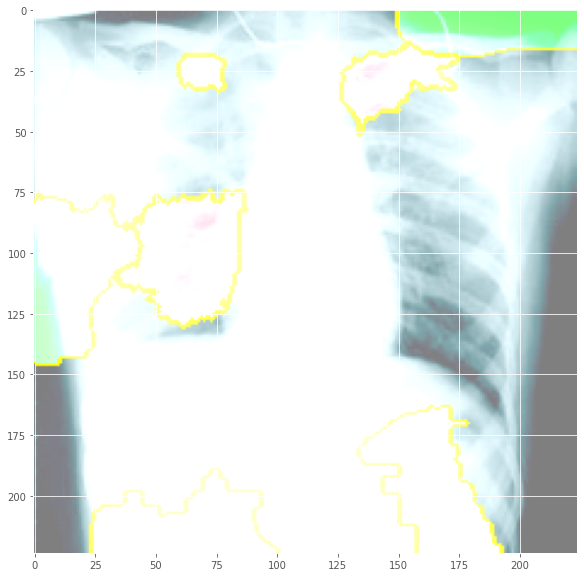


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


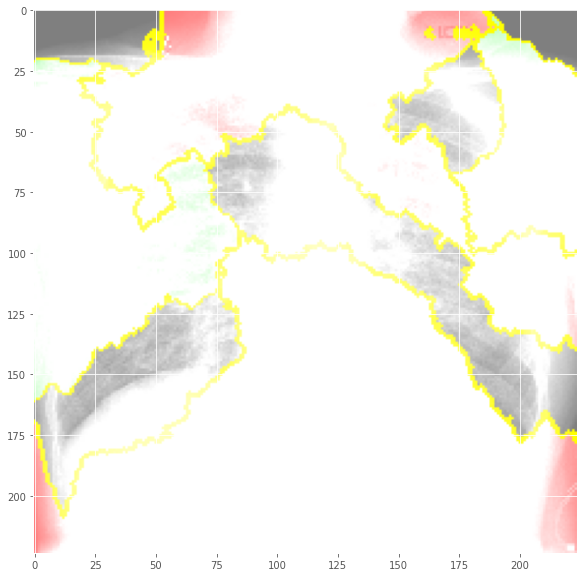


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


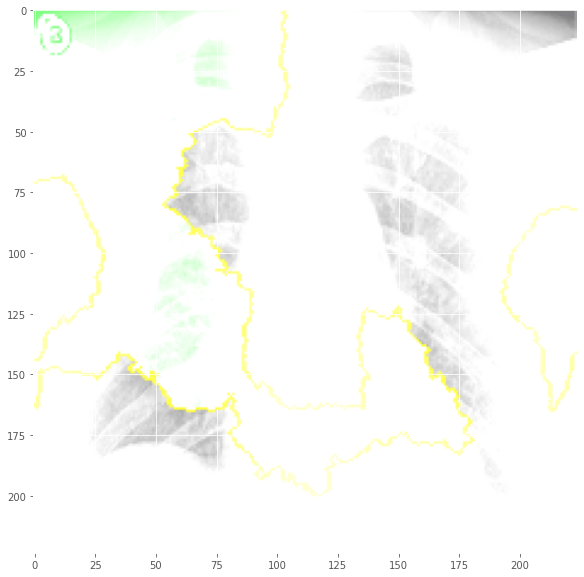


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


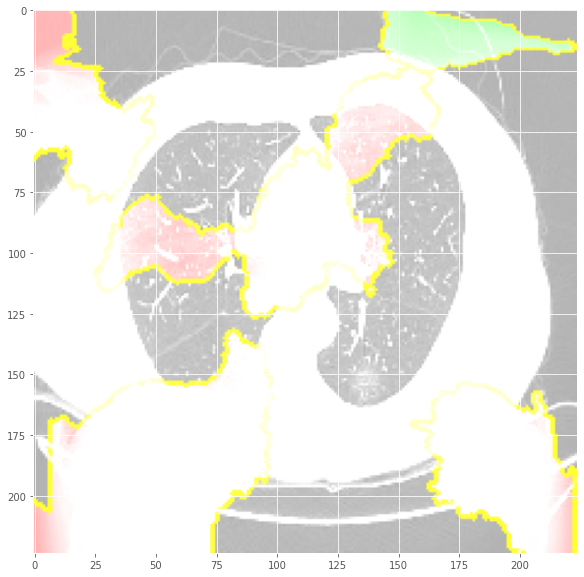


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


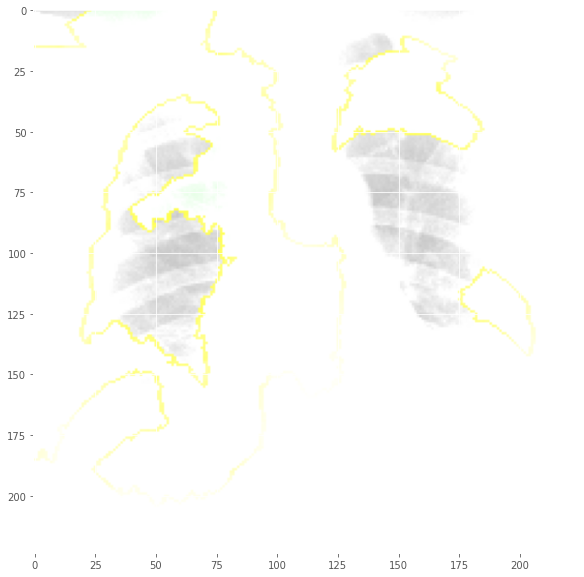

In [10]:
plt.figure(2)
for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)+testX[ind])
    plt.show()